# Lab 3 : Data Mining

---

## Made By :


1.   Amr Mohamed Nasreldin Elsayed (47)
2.   Michael Raafat (57)


---

This lab is a full exploration, and modeling of the MAGIC gamma telescope dataset. It will use multiple preprocessing techniques and compare between them, and compare also between different models such as Naive Bayesian Classifer, SVM, Decision Tree, K-NN, and ensemble techniques such as Random forests and AdaBoost. 

---





In [0]:
# Import Used Libraries.
import csv
import random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as cs
from scipy.misc import imshow
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn import tree
!pip install -q graphviz
import graphviz 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

distributed 1.21.8 requires msgpack, which is not installed.
jupyter-console 5.1.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 2.0.7 which is incompatible.
tensorflow 1.9.0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.6.2 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Exploring The Dataset


---

We begin by loading the dataset, and exploring it. To do that, we define multiple functions then use these function, to read the data set, and do multiple visualization which will give us important information.

In [0]:
# Number of threads.
num_jobs = 8
# Reads a magic csv file.
def read_magic_data(file_directory):
  # Open up the file.
  f = open(file_directory)
  # Read line containing column names.
  headers = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
  # Read data as matrix of strings.
  data = np.loadtxt(f, dtype = np.dtype(str),delimiter = ',')
  # Parse numbers as floats.
  x = data[:,:10].astype(np.dtype(float))
  # Transform categorical data classes to numbers.
  y = data[:,10]
  b, c = np.unique(y, return_inverse=True)
  # Make our data structured again.
  data[:,10] = c
  data[:,:10] = x
  data = data.astype(np.dtype(float))
  return data, headers, b

In [0]:
## Do histogram for each class all with same bin size.
def visualise_data_histograms_same_bin_size(X, x_columns, class_jump=6688):
  bin_nums = [5, 10, 12] 
  cm = plt.cm.get_cmap('tab20')
  for i in range(len(y_labels)):
    fig, axes = plt.subplots(1,len(bin_nums) + 1)
    fig.suptitle(y_labels[i], fontsize = 16)
    axe_ind = 0
    for bin_num in bin_nums:
      ax = axes[axe_ind]
      ax.set_xlabel('features ' + str(bin_num) + ' bins')
      ax.set_ylabel('Frequency')
      ax.hist(X[i * class_jump: (i+1)* class_jump, :], bins = bin_num,label=x_columns)
      axe_ind = axe_ind + 1
    handles, labels = axes[0].get_legend_handles_labels()
    axes[len(bin_nums)].legend(handles, labels, loc='upper right')
    fig.subplots_adjust(left=0.125, bottom=0.1,
                        right=2.5, top=0.9,
                        wspace=0.1, hspace=0.1)
    plt.show() 
## Do histogram for each class.
def visualise_data_histograms(X, x_columns, class_jump=6688):
  bin_nums = [5, 10, 12] 
  cm = plt.cm.get_cmap('tab20')
  for i in range(len(y_labels)):
    fig, axes = plt.subplots(1,len(bin_nums) + 1)
    fig.suptitle(y_labels[i], fontsize = 16)
    axe_ind = 0
    for bin_num in bin_nums:
      ax = axes[axe_ind]
      ax.set_xlabel('features ' + str(bin_num) + ' bins')
      ax.set_ylabel('Frequency')
      for j in range(len(x_columns)):
        ax.hist(X[i * class_jump: (i+1)* class_jump, j], bins = bin_num,label=x_columns[j], color = cm(j))
      axe_ind = axe_ind + 1
    handles, labels = axes[0].get_legend_handles_labels()
    axes[len(bin_nums)].legend(handles, labels, loc='upper right')
    fig.subplots_adjust(left=0.125, bottom=0.1,
                        right=2.5, top=0.9,
                        wspace=0.1, hspace=0.1)
    plt.show()  

In [0]:
# Displays Pearson Correlation Coeffecient in a matrix plot.
def visualize_pearson(X, x_columns):
# Computing the Pearson’s correlation coefficient between each 2 attributes
  correlation_coef_mat = np.zeros((len(x_columns),len(x_columns)))
  for i in range(len(x_columns)):
    for j in range(i,len(x_columns)):
      r, p_value = pearsonr(X[:,i],X[:,j])
      correlation_coef_mat[i,j] = r
      correlation_coef_mat[j,i] = r
  # Plot Pearson 
  fig, ax = plt.subplots()
  fig.suptitle('Pearson Correlation coefficient')
  im = ax.imshow(correlation_coef_mat, cmap=plt.get_cmap('hot'), interpolation='nearest', vmin=-1, vmax=1)
  fig.colorbar(im)
  ax.set_xticks(np.arange(len(x_columns)))
  ax.set_xticklabels(x_columns, rotation = 'vertical')
  ax.set_yticks(np.arange(len(x_columns)))
  ax.set_yticklabels(x_columns)
  plt.show()

In [0]:
## Do boxplots for each class
def visualise_data_boxplots(X, x_columns, class_jump=6688):
  for i in range(len(y_labels)):
    plt.title(y_labels[i], fontsize = 16)
    plt.boxplot(X[i*class_jump : (i + 1) * class_jump], 0, 'gD')
    plt.xticks(np.arange(1,len(x_columns) + 1), x_columns, rotation='vertical')
    plt.show()   

### Getting the data ready


---

After loading the data set, we notice a problem which is the class imbalance problem in the data set, which we fix by randomly removing samples from the more populated class, until they are even.

---
### Exploring Data Notes

---


*  We can notice from the histograms the while most of the features have the same median of distribution, their standard deviation is not the same, and there are features who do not have the same numeric range as the others which might make some models perform badly.
* The box plots verify this observation, but also points us that the two classes don't have a single feature that easily seperates them.
* The correlation matrix shows us the correlation between attributes, which is information we might use of we decide utilize feature selection to improve the models, as if we remove correlated features, we can reduce our data to mainly ('fConc', 'fAsym', 'fM3Trans', 'fAlpha' ).

---



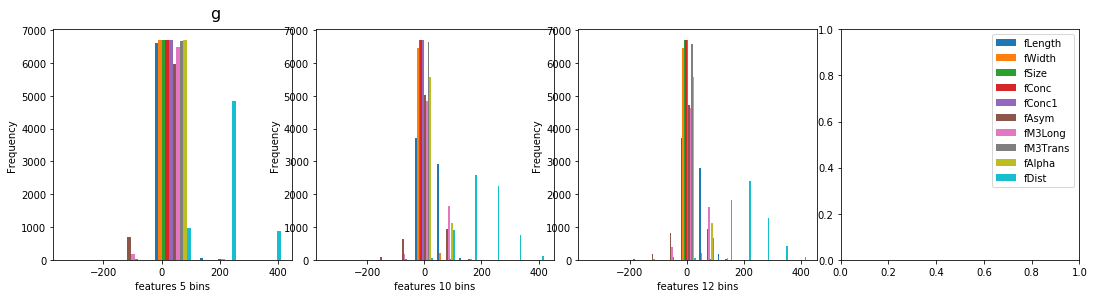

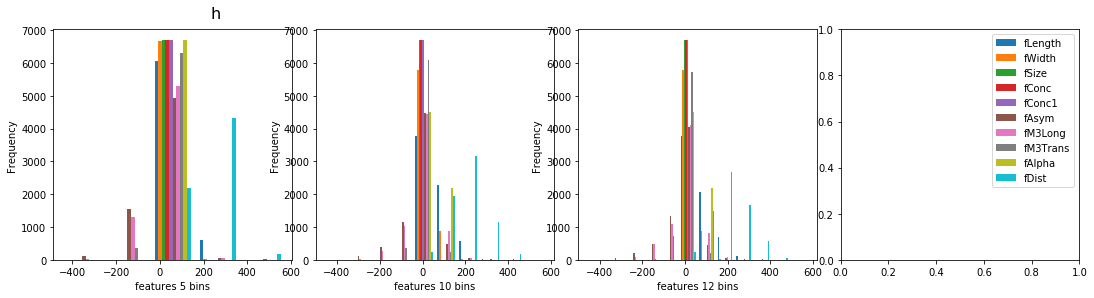

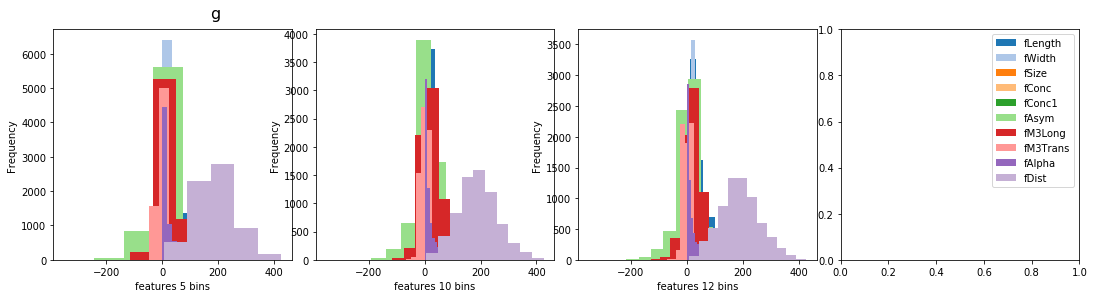

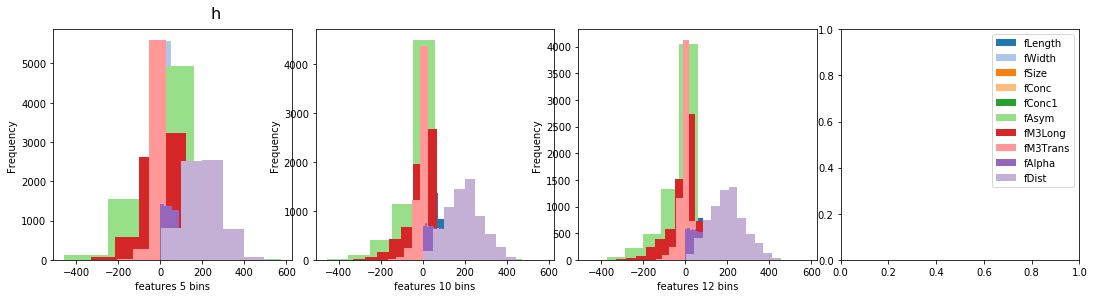

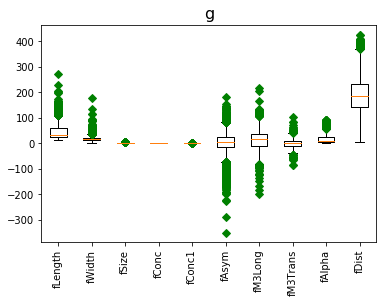

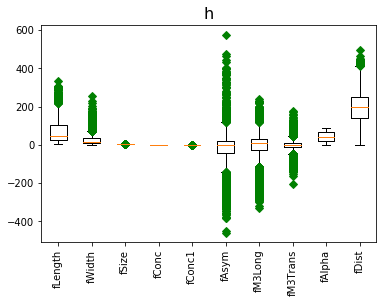

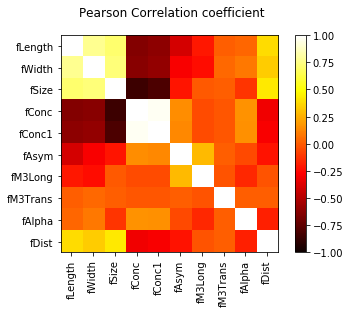

In [0]:
data, headers, label_train_y = read_magic_data("magic04.data.txt")
data = data[data[:,10].argsort(),:]
random.seed( 3 )
# remove randomly 5644 element from "g" 
for i in range(5644):
  data = np.delete(data, random.randrange(12332 - i), 0)
X = data[:,:10]
x_columns = headers[:10]
y_labels = label_train_y
visualise_data_histograms_same_bin_size(X,x_columns)
visualise_data_histograms(X,x_columns)
visualise_data_boxplots(X,x_columns)
visualize_pearson(X,x_columns)


## Getting Ready For Modeling
We will split our dataset using a stratified split(Keeping class balance) into a training set and a test set to be able to compare the different models, and the test set will not be used in any other purpose than to compare the different classification models. Our training set will be 70% of our data and the rest will be the test set.

---

In [0]:
#split into 30% test and 70% training
np.random.seed( 3 )
def split_data(data):
  first_class = data[:6688,:]
  second_class = data[6688:,:]
  np.random.shuffle(first_class)
  np.random.shuffle(second_class)
  fc_s = first_class
  sc_s = second_class
  fc_test = fc_s[:2006,:]
  fc_train = fc_s[2006:,:]
  sc_test = sc_s[:2006,:]
  sc_train = sc_s[2006:,:]
  data_train = np.vstack([fc_train, sc_train])
  data_test = np.vstack([fc_test, sc_test])
  return data_train, data_test
data_train, data_test = split_data(data)

X_train = data_train[:,:10]
X_test = data_test[:,:10]
y_label_train = data_train[:,10]
y_label_test = data_test[:,10]
print('Train Data Set Percentage : ', (len(X_train)/ len(data)) * 100, '%')
print('Test Data Set Percentage : ', (len(X_test)/ len(data)) * 100, '%')

Train Data Set Percentage :  70.00598086124403 %
Test Data Set Percentage :  29.994019138755977 %


In [0]:
def visualise_data_boxplot(X, y, x_columns, y_labels):
  Xm = np.copy(X)
  X1 = []
  X2 = []
  for i in range(len(Xm)):
    if (y[i] == 0):
      X1.append(Xm[i,:])
    else:
      X2.append(Xm[i,:])
  X1 = np.asarray(X1)
  X2 = np.asarray(X2)
  plt.title(y_labels[0], fontsize = 16)
  plt.boxplot(X1, 0, 'gD')
  plt.xticks(np.arange(1,len(x_columns) + 1), x_columns, rotation='vertical')
  plt.show()
  plt.title(y_labels[1], fontsize = 16)
  plt.boxplot(X2, 0, 'gD')
  plt.xticks(np.arange(1,len(x_columns) + 1), x_columns, rotation='vertical')
  plt.show()

## Data Preprocessing


---

We utilized 3 techniques in preprocessing :


1.   Normalization using min and max, and as shown by the boxplots, has the problem of being affected by the outliers and it is obvious it won't perform better due to that fact, but it can be useful if K-NN is used.
2.   Standardization, making the mean and standard deviation of our data 0 and 1 respectively. This makes our data balanced and show that the feature are almost evenly distributed
3.   Principal Component Analysis, used to rotate our data to the directions that capture the variance, and not used to reduce dimensionality, and we can notice that almost each component add to the variance a respectfull amount which verifies our opinion that almost all the features are usefull in this dataset.

---


Minmax Data


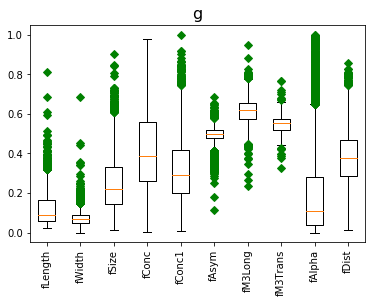

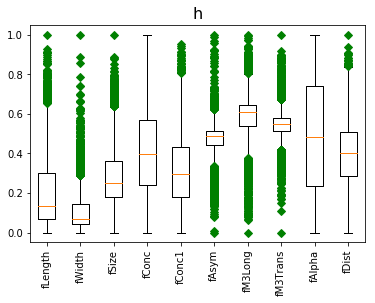

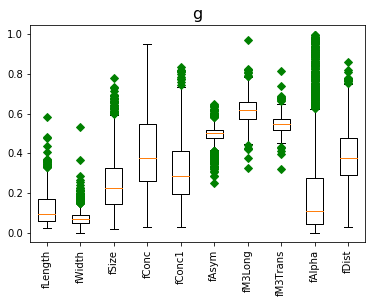

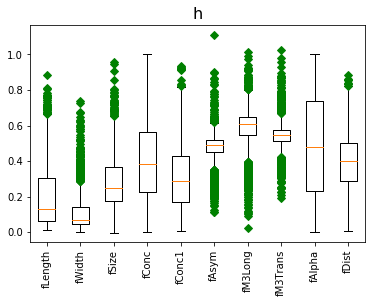

Z-Score Data


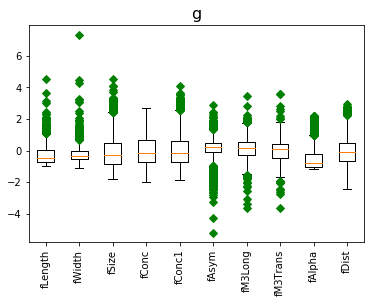

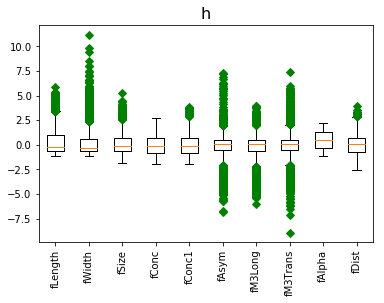

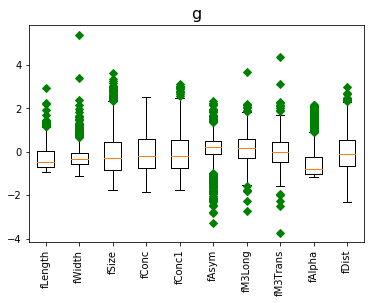

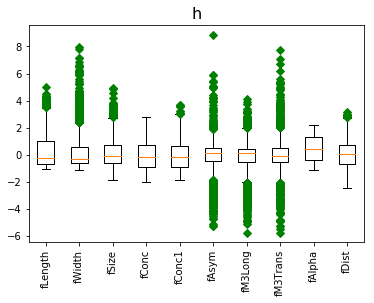

In [0]:
# Normalization using min max scalar & Z-Score
print('Minmax Data')
scaler = MinMaxScaler()
scaler.fit(X_train)
minmax_X_train = scaler.transform(X_train)
minmax_X_test = scaler.transform(X_test)
visualise_data_boxplot(minmax_X_train, y_label_train, x_columns, y_labels)
visualise_data_boxplot(minmax_X_test, y_label_test, x_columns, y_labels)


# Standardlization
print('Z-Score Data')
z_scaler = preprocessing.StandardScaler().fit(X_train)
z_score_X_train = z_scaler.transform(X_train)
z_score_X_test = z_scaler.transform(X_test)
visualise_data_boxplot(z_score_X_train, y_label_train, x_columns, y_labels)
visualise_data_boxplot(z_score_X_test, y_label_test, x_columns, y_labels)



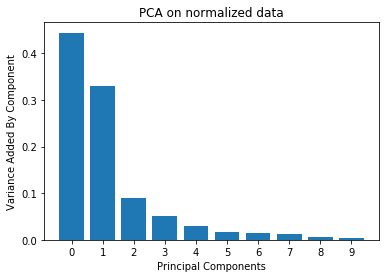

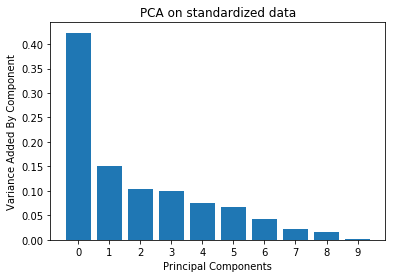

Amount of variance captured :  [0.42312383 0.57426501 0.67707021 0.77616425 0.85165085 0.91798305
 0.9600558  0.98222364 0.99789611 1.        ]


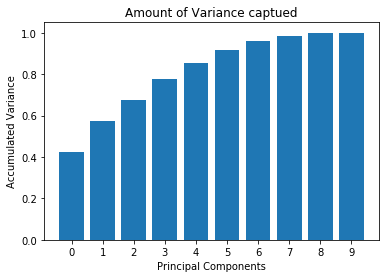

In [0]:
# Feature Projection Draw PCA contribution to variance.
pca = PCA(n_components=len(x_columns))
pca.fit(minmax_X_train)
plt.title('PCA on normalized data')
plt.bar(np.arange(len(x_columns)), pca.explained_variance_ratio_ )
plt.xticks(np.arange(len(x_columns)))
plt.xlabel('Principal Components')
plt.ylabel('Variance Added By Component')
plt.show()


pca = PCA(n_components=len(x_columns))
pca.fit(z_score_X_train)
plt.title('PCA on standardized data')
plt.bar(np.arange(len(x_columns)), pca.explained_variance_ratio_ )
plt.xticks(np.arange(len(x_columns)))
plt.xlabel('Principal Components')
plt.ylabel('Variance Added By Component')
plt.show()

pca_res = np.cumsum(pca.explained_variance_ratio_)
print('Amount of variance captured : ', pca_res)
plt.title('Amount of Variance captued')
plt.bar(np.arange(len(x_columns)), pca_res )
plt.xticks(np.arange(len(x_columns)))
plt.xlabel('Principal Components')
plt.ylabel('Accumulated Variance')
plt.show()

pca = PCA(n_components=len(x_columns))
pca.fit(z_score_X_train)
pca_X_train = pca.transform(z_score_X_train)
pca_X_test = pca.transform(z_score_X_test)

## Classfication & Parameter Tuning
---
### Work Flow
* We defined a function that will take the train and testing data and the model, and print out all the interesting statistques and information. This function will be the only one that uses the test data, which means our test data will be kept unseen until the final model evaluation.
* In models that need tuning, we will perform a grid search with cross-validation to get the values of the hyperparameters, then get the performance of our best model to compare it to the other algorithms.
* We will perform this algorithm on the multiple formats of our data set to compare the effects of the preprocessing.
---

In [0]:
def print_stats(estimator, X_train, y_train, X_test, y_test):
  y_pred_train = estimator.predict(X_train)
  y_pred_test = estimator.predict(X_test)
  print('Train Set Accuracy : ', accuracy_score(y_train, y_pred_train))
  print('Train Set Precision : ', precision_score(y_train, y_pred_train))
  print('Train Set Recall : ', recall_score(y_train, y_pred_train))
  print('Train F-Score for each class : ', f1_score(y_train, y_pred_train, average=None))
  print('Train Mean F-Score for both classes : ',f1_score(y_train, y_pred_train, average='macro'))
  print('Train Confusion Matrix : ', confusion_matrix(y_train, y_pred_train))
  print('----------------------------------------------------------------------')
  print('Test Set Accuracy : ', accuracy_score(y_test, y_pred_test))
  print('Test Set Precision : ', precision_score(y_test, y_pred_test))
  print('Test Set Recall : ', recall_score(y_test, y_pred_test))
  print('Test F-Score for each class : ', f1_score(y_test, y_pred_test, average=None))
  print('Test Mean F-Score for both classes : ',f1_score(y_test, y_pred_test, average='macro'))
  print('Test Confusion Matrix : ', confusion_matrix(y_test, y_pred_test))
  print('----------------------------------------------------------------------')


### Decision Trees
* We tested our decision trees using two criteras for the splitting : Gini & Entropy.
* In gini, we notice the original data outperforming, the standard data, which outperforms the PCA. This can be explained that the original and the standard data were easier to seperate by horizonatl and vertical lines than when rotated with the PCA, and the same goes for the standard but it remains very close to the original data which means it might be a negligent difference.
* In entropy, interestingly the standard data beats the original by a small margin as well, however the pca still does poorly in comparison which solidifies our previous theory.
* We try to improve performance by tuning pre-pruning hyper-parameters, using a grid search on two hyper-parameters.
* We managed to improve the performance by pre-pruning by making the decision trees more general thus preventing overfitting to a certain degree.
* Without Pre-Pruning, our best F-score is 0.7928379102103247 by using entropy with the standardized data.
* With Pre-Pruning, our best F-score is 0.8101840289791009 by using entropy with the original data, this means our performance might even get better if we pre-prune on the standard data.

In [0]:
def decisionTreeModel(X_train, y_label_train, X_test, y_label_test, min_sample_split=2, min_sample_leaf=1,criterion='gini'):
  clf = tree.DecisionTreeClassifier(criterion = criterion, min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf)
  clf = clf.fit(X_train, y_label_train)
  print_stats(clf, X_train, y_label_train, X_test, y_label_test)

def decisionTreeModelSearch(X_train, y_label_train, X_test, y_label_test, mls, mls_n, mms, mms_n, criterion):
  clf = tree.DecisionTreeClassifier(criterion = criterion)
  min_sample_leaf = np.linspace(mls, mls + mls_n, mls_n).astype(int)
  min_sample_split = np.linspace(mms, mms + mms_n, mms_n).astype(int)
  parameters = {'min_samples_split': min_sample_split, 'min_samples_leaf':min_sample_leaf}
  gDt = GridSearchCV(clf, parameters,scoring = 'f1_macro', cv = 5, n_jobs = num_jobs)
  gDt.fit(X_train, y_label_train)
  print('Best paramters found at ', gDt.best_params_)
  print('Best Mean F-Score ', gDt.best_score_)
  cs_1 = gDt.cv_results_['param_min_samples_leaf']
  cs_2 = gDt.cv_results_['param_min_samples_split']
  cs_score = gDt.cv_results_['mean_test_score']
  mean_f_scores = np.zeros((mls_n + 1, mms_n + 1))
  for j in range(len(cs_1)):
      mean_f_scores[cs_1[j] - mls, cs_2[j] - mms] = cs_score[j]
  # Plot Accuracy on validation set.
  min_sample_leaf = np.linspace(mls, mls + mls_n + 1, mls_n + 1)
  min_sample_split = np.linspace(mms, mms + mms_n + 1, mms_n + 1)
  x = np.zeros((11))
  y = np.zeros((11))
  mat = np.zeros((11,11))
  for i in range(11):
    for j in range(11):
      mat[i, j] = mean_f_scores[3*i,3*j]
      x[i] = 3 * i + mls
      y[j] = 3 * j + mms
  plt.title('Mean F-Score at different sample limit in leaf')
  xv, xy = np.meshgrid(y, x)
  CS = plt.contour(xv, xy , mat)
  plt.clabel(CS, inline=1, fontsize=10)
  plt.ylabel('Min. Leaf Samples')
  plt.xlabel('Min. Split Samples')
  plt.show()
  print_stats(gDt, X_train, y_label_train, X_test, y_label_test)

Original Data Decision Tree(GINI) : 
Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7948654037886341
Test Set Precision :  0.8069538142189933
Test Set Recall :  0.7751744765702892
Test F-Score for each class :  [0.79882669 0.79074498]
Test Mean F-Score for both classes :  0.7947858355640802
Test Confusion Matrix :  [[1634  372]
 [ 451 1555]]
----------------------------------------------------------------------

Standardized Data Decision Tree(GINI) : 
Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------

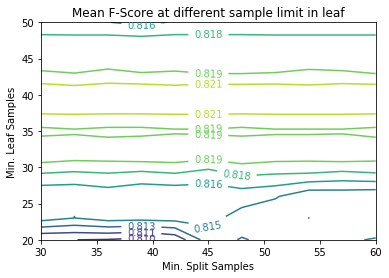

Train Set Accuracy :  0.8473942759504485
Train Set Precision :  0.8589715294636946
Train Set Recall :  0.8312686885946177
Train F-Score for each class :  [0.84981608 0.84489309]
Train Mean F-Score for both classes :  0.8473545828654123
Train Confusion Matrix :  [[4043  639]
 [ 790 3892]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8058325024925225
Test Set Precision :  0.8183705241307733
Test Set Recall :  0.7861415752741775
Test F-Score for each class :  [0.80958201 0.80193237]
Test Mean F-Score for both classes :  0.8057571882192205
Test Confusion Matrix :  [[1656  350]
 [ 429 1577]]
----------------------------------------------------------------------

Entropy Criterion
Best paramters found at  {'min_samples_leaf': 37, 'min_samples_split': 33}
Best Mean F-Score  0.8157402932225715


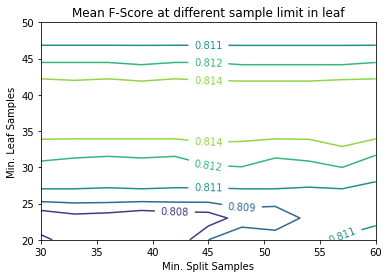

Train Set Accuracy :  0.8467535241349851
Train Set Precision :  0.8575203699625633
Train Set Recall :  0.8316958564715934
Train F-Score for each class :  [0.84902683 0.84441071]
Train Mean F-Score for both classes :  0.8467187701674158
Train Confusion Matrix :  [[4035  647]
 [ 788 3894]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8103190428713859
Test Set Precision :  0.8278041074249605
Test Set Recall :  0.7836490528414756
Test F-Score for each class :  [0.81524642 0.80512164]
Test Mean F-Score for both classes :  0.8101840289791009
Test Confusion Matrix :  [[1679  327]
 [ 434 1572]]
----------------------------------------------------------------------



In [0]:
#Decision tree before Z-Score
print('Original Data Decision Tree(GINI) : ')
decisionTreeModel(X_train, y_label_train, X_test, y_label_test, criterion='entropy')
print()
# Decision tree after Z-score
print('Standardized Data Decision Tree(GINI) : ')
decisionTreeModel(z_score_X_train, y_label_train, z_score_X_test, y_label_test, criterion='entropy')
print()
# Decision tree after pca
print('PCA Data Decision Tree(GINI) : ')
decisionTreeModel(pca_X_train, y_label_train, pca_X_test, y_label_test, criterion='entropy')
print()

#Decision tree before Z-Score
print('Original Data Decision Tree(Entropy) : ')
decisionTreeModel(X_train, y_label_train, X_test, y_label_test, criterion='entropy')
print()
# Decision tree after Z-score
print('Standardized Data Decision Tree(Entropy) : ')
decisionTreeModel(z_score_X_train, y_label_train, z_score_X_test, y_label_test, criterion='entropy')
print()
# Decision tree after pca
print('PCA Data Decision Tree(Entropy) : ')
decisionTreeModel(pca_X_train, y_label_train, pca_X_test, y_label_test, criterion='entropy')
print()
# Search for some prunning hyperparameters.
h_num_leaf = 30
h_num_split = 30
h_start_leaf = 20
h_start_split = 30
print('Gini Criterion')
decisionTreeModelSearch(X_train, y_label_train, X_test, y_label_test, h_start_leaf, h_num_leaf, h_start_split, h_num_split, 'gini')
print()
print('Entropy Criterion')
decisionTreeModelSearch(X_train, y_label_train, X_test, y_label_test, h_start_leaf, h_num_leaf, h_start_split, h_num_split, 'entropy')
print()

### Naive-Bayesian Classifier
* Gives us the same performance on original and standard data which is logical since they only change scale and naive-bayes is probability based.
* Bad performance which can be explained by the data breaking the conditionally independent given the class assumption.
* PCA helps improve it, which is logical since PCA rotates the data into principal components which represent a new combination of features, meaning these new 'features' now representing the sample might by closer to the conditionally independent given the class assumption which seems to be our case.
* Naive-Bayesian on the PCA-Modified data gives us the F-score 0.6894654751507103 which is the highest achived in Naive-Bayes.


In [0]:
def naiveBayesModel(X_train, y_label_train, X_test, y_label_test):
  gnb = GaussianNB()
  gnb.fit(X_train, y_label_train)
  print_stats(gnb, X_train, y_label_train, X_test, y_label_test)


In [0]:
# Naive Bayes before Z-score
print('Naive Bayes Original Data : ')
naiveBayesModel(X_train, y_label_train, X_test, y_label_test)
print()
# Naive Bayes after Z-score
print('Naive Bayes Standardized Data : ')
naiveBayesModel(z_score_X_train, y_label_train, z_score_X_test, y_label_test)
print()
print('Naive Bayes Pca data : ')
naiveBayesModel(pca_X_train, y_label_train, pca_X_test, y_label_test)

Naive Bayes Original Data : 
Train Set Accuracy :  0.651964972234088
Train Set Precision :  0.7973255328040117
Train Set Recall :  0.4075181546347715
Train F-Score for each class :  [0.72032953 0.53936396]
Train Mean F-Score for both classes :  0.6298467432369287
Train Confusion Matrix :  [[4197  485]
 [2774 1908]]
----------------------------------------------------------------------
Test Set Accuracy :  0.6470588235294118
Test Set Precision :  0.791501976284585
Test Set Recall :  0.39930209371884345
Test F-Score for each class :  [0.71713943 0.53081511]
Test Mean F-Score for both classes :  0.6239772710123597
Test Confusion Matrix :  [[1795  211]
 [1205  801]]
----------------------------------------------------------------------

Naive Bayes Standardized Data : 
Train Set Accuracy :  0.651964972234088
Train Set Precision :  0.7973255328040117
Train Set Recall :  0.4075181546347715
Train F-Score for each class :  [0.72032953 0.53936396]
Train Mean F-Score for both classes :  0.629846

### K-NN
* Trying to tune the hyperparameter of the nearest neighbour number using grid search with cross-validation.
* Logically all transformed data perform better than original since they are scalled, with the min max doing the best since it keeps all features in the range of values. making each feature contribute to the distance equally which improves K-NN performance.
* K-NN on normalized data gives us F-score of 0.8090860040466614 when number of neighbours is 13  which is the best for K-NN.

In [0]:
#KNN
def kNearestNeighborsModel(X_train, y_label_train, X_test, y_label_test, start_n, end_n):
  parameters = {'n_neighbors': list(range(start_n, end_n))}
  KNNC =  KNeighborsClassifier(n_jobs = num_jobs)
  gKnn = GridSearchCV(KNNC, parameters,scoring = 'f1_macro', cv = 5, n_jobs = num_jobs)
  gKnn.fit(X_train, y_label_train)
  print('Best N found at ', gKnn.best_params_)
  print('Best Mean F-Score ', gKnn.best_score_)
  ns = gKnn.cv_results_['param_n_neighbors']
  ns_score = gKnn.cv_results_['mean_test_score']
  plt.title('Mean F-Score with different neighbors')
  plt.plot(ns, ns_score)
  plt.xlabel('# of neighbours')
  plt.ylabel('Validation Mean F-Score')
  plt.show()
  print_stats(gKnn, X_train, y_label_train, X_test, y_label_test)


KNN Original Data : 
Best N found at  {'n_neighbors': 11}
Best Mean F-Score  0.7674708960797587


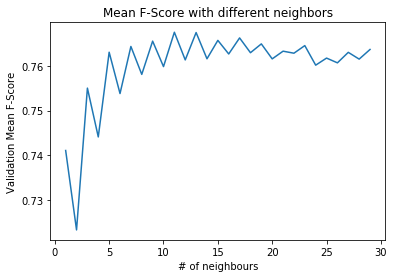

Train Set Accuracy :  0.8082016232379325
Train Set Precision :  0.8625628140703517
Train Set Recall :  0.7332336608287057
Train F-Score for each class :  [0.82157759 0.79265758]
Train Mean F-Score for both classes :  0.8071175863865563
Train Confusion Matrix :  [[4135  547]
 [1249 3433]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7674476570289133
Test Set Precision :  0.8309685379395435
Test Set Recall :  0.6714855433698903
Test F-Score for each class :  [0.78780987 0.74276261]
Test Mean F-Score for both classes :  0.7652862420482571
Test Confusion Matrix :  [[1732  274]
 [ 659 1347]]
----------------------------------------------------------------------

KNN Standardized Data : 
Best N found at  {'n_neighbors': 11}
Best Mean F-Score  0.8089630820994435


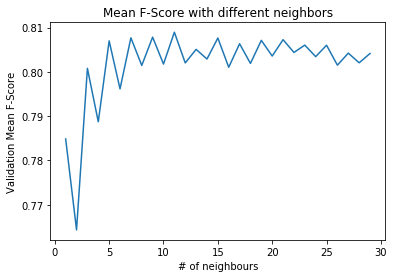

Train Set Accuracy :  0.8429090132422042
Train Set Precision :  0.9016762571928947
Train Set Recall :  0.7697565143101239
Train F-Score for each class :  [0.85361728 0.83051043]
Train Mean F-Score for both classes :  0.8420638514096919
Train Confusion Matrix :  [[4289  393]
 [1078 3604]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8058325024925225
Test Set Precision :  0.8645276292335116
Test Set Recall :  0.7253240279162513
Test F-Score for each class :  [0.82029988 0.78883166]
Test Mean F-Score for both classes :  0.8045657731783415
Test Confusion Matrix :  [[1778  228]
 [ 551 1455]]
----------------------------------------------------------------------

KNN Normalized Data : 
Best N found at  {'n_neighbors': 13}
Best Mean F-Score  0.8085521933123571


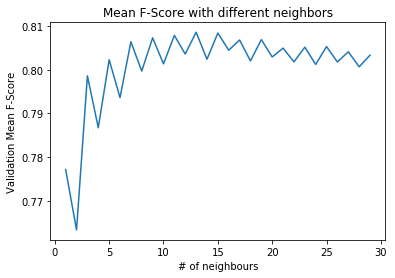

Train Set Accuracy :  0.8356471593336181
Train Set Precision :  0.8837606837606837
Train Set Recall :  0.7729602733874412
Train F-Score for each class :  [0.84534218 0.82465535]
Train Mean F-Score for both classes :  0.8349987629369098
Train Confusion Matrix :  [[4206  476]
 [1063 3619]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8100697906281157
Test Set Precision :  0.8620488940628638
Test Set Recall :  0.7382851445663011
Test F-Score for each class :  [0.8227907  0.79538131]
Test Mean F-Score for both classes :  0.8090860040466614
Test Confusion Matrix :  [[1769  237]
 [ 525 1481]]
----------------------------------------------------------------------

KNN Pca Data : 
Best N found at  {'n_neighbors': 11}
Best Mean F-Score  0.8089630820994435


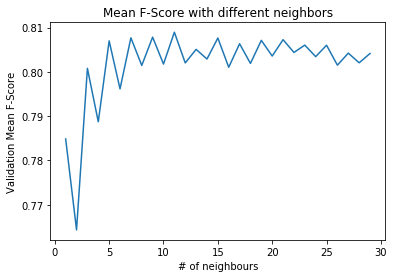

Train Set Accuracy :  0.8429090132422042
Train Set Precision :  0.9016762571928947
Train Set Recall :  0.7697565143101239
Train F-Score for each class :  [0.85361728 0.83051043]
Train Mean F-Score for both classes :  0.8420638514096919
Train Confusion Matrix :  [[4289  393]
 [1078 3604]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8058325024925225
Test Set Precision :  0.8645276292335116
Test Set Recall :  0.7253240279162513
Test F-Score for each class :  [0.82029988 0.78883166]
Test Mean F-Score for both classes :  0.8045657731783415
Test Confusion Matrix :  [[1778  228]
 [ 551 1455]]
----------------------------------------------------------------------



In [0]:
start_n = 1
end_n = 30
print('KNN Original Data : ')
kNearestNeighborsModel(X_train, y_label_train, X_test, y_label_test, start_n, end_n)
print()
print('KNN Standardized Data : ')
kNearestNeighborsModel(z_score_X_train, y_label_train, z_score_X_test, y_label_test, start_n, end_n)
print()
print('KNN Normalized Data : ')
kNearestNeighborsModel(minmax_X_train, y_label_train, minmax_X_test, y_label_test, start_n, end_n)
print()
print('KNN Pca Data : ')
kNearestNeighborsModel(pca_X_train, y_label_train, pca_X_test, y_label_test, start_n, end_n)
print()

### SVM
* Linear SVM with C as hyperparameter to tune using grid search.
* Perform poorly with the original data, and performs best with the PCA data, which could mean that the pca transformation could lead to the data being more easily separable with a line, due to the different scaling in the PCA, which also explains why performance improved on the standard data as well.
* Best F-Score was 0.7733462801232129 with PCA-Modified data and C = 10

In [0]:
#SVM
def svmModel(X_train, y_label_train, X_test, y_label_test, c_para):
  clf = LinearSVC()
  parameters = {'C': c_para}
  gSvm = GridSearchCV(clf, parameters,scoring = 'f1_macro', cv = 5, n_jobs = num_jobs)
  gSvm.fit(X_train, y_label_train)
  print('Best C found at ', gSvm.best_params_)
  print('Best Mean F-Score ', gSvm.best_score_)
  cs = gSvm.cv_results_['param_C']
  cs_score = gSvm.cv_results_['mean_test_score']
  plt.title('Mean F-Score with C')
  plt.plot(cs, cs_score)
  plt.xlabel('C value')
  plt.ylabel('Validation Mean F-Score')
  plt.show()
  print_stats(gSvm, X_train, y_label_train, X_test, y_label_test)


SVM original data
Best C found at  {'C': 100}
Best Mean F-Score  0.6272805749441773


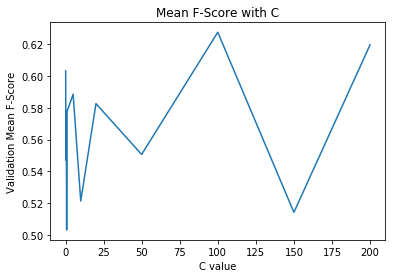

Train Set Accuracy :  0.6581589064502349
Train Set Precision :  0.7586447782046805
Train Set Recall :  0.46390431439555746
Train F-Score for each class :  [0.71376196 0.57574553]
Train Mean F-Score for both classes :  0.6447537434785012
Train Confusion Matrix :  [[3991  691]
 [2510 2172]]
----------------------------------------------------------------------
Test Set Accuracy :  0.6468095712861416
Test Set Precision :  0.7369267900241352
Test Set Recall :  0.45663010967098705
Test F-Score for each class :  [0.70324607 0.5638658 ]
Test Mean F-Score for both classes :  0.6335559390807322
Test Confusion Matrix :  [[1679  327]
 [1090  916]]
----------------------------------------------------------------------

SVM standardized data
Best C found at  {'C': 20}
Best Mean F-Score  0.770021424064951


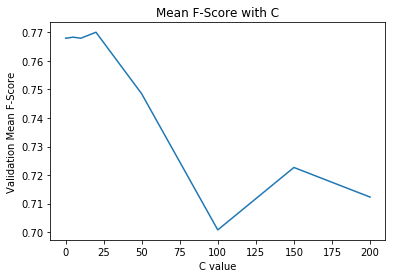

Train Set Accuracy :  0.7696497223408799
Train Set Precision :  0.801961253288687
Train Set Recall :  0.7161469457496796
Train F-Score for each class :  [0.7813482  0.75662868]
Train Mean F-Score for both classes :  0.7689884408715448
Train Confusion Matrix :  [[3854  828]
 [1329 3353]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7729312063808574
Test Set Precision :  0.8181289947704823
Test Set Recall :  0.7018943170488534
Test F-Score for each class :  [0.78799162 0.75556748]
Test Mean F-Score for both classes :  0.7717795513046304
Test Confusion Matrix :  [[1693  313]
 [ 598 1408]]
----------------------------------------------------------------------

SVM Pca data
Best C found at  {'C': 10}
Best Mean F-Score  0.7690625671054712


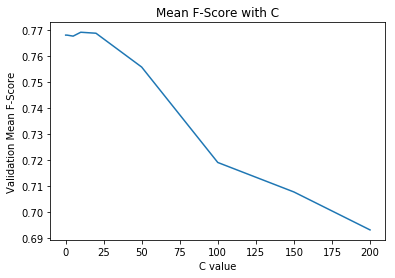

Train Set Accuracy :  0.7700768902178556
Train Set Precision :  0.8055085769509543
Train Set Recall :  0.7120888509184109
Train F-Score for each class :  [0.78267891 0.75592336]
Train Mean F-Score for both classes :  0.7693011392985716
Train Confusion Matrix :  [[3877  805]
 [1348 3334]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7744267198404786
Test Set Precision :  0.8183921341816078
Test Set Recall :  0.7053838484546361
Test F-Score for each class :  [0.7889951  0.75769746]
Test Mean F-Score for both classes :  0.7733462801232129
Test Confusion Matrix :  [[1692  314]
 [ 591 1415]]
----------------------------------------------------------------------



In [0]:
c = [0.1, 0.25, 0.5, 0.75, 1, 5, 10, 20, 50, 100, 150, 200]
print('SVM original data')
svmModel(X_train, y_label_train, X_test, y_label_test, c)
print()
c = [0.1, 0.25, 0.5, 0.75, 1, 5, 10, 20, 50, 100, 150, 200]
print('SVM standardized data')
svmModel(z_score_X_train, y_label_train, z_score_X_test, y_label_test, c)
print()
c = [0.1, 0.25, 0.5, 0.75, 1, 5, 10, 20, 50, 100, 150, 200]
print('SVM Pca data')
svmModel(pca_X_train, y_label_train, pca_X_test, y_label_test, c)
print()


## Random Forests
* Random forests performed best with original data, which is consistent with what we got from the decision trees.
* Best F-Score 0.858037666570339 with original data with number of estimators = 130
* Ensemble methods can increase number of estimators with much worry of performance degredation but will increase time of training and prediction due to increasing the computations

In [0]:
# Random Forests
def randomForestModel(X_train, y_label_train, X_test, y_label_test, n):
  clf = RandomForestClassifier(n_jobs = num_jobs)
  parameters = {'n_estimators': n}
  gRf = GridSearchCV(clf, parameters,scoring = 'f1_macro', cv = 5, n_jobs = num_jobs)
  gRf.fit(X_train, y_label_train)
  print('Best n found at ', gRf.best_params_)
  print('Best Mean F-Score ', gRf.best_score_)
  cs = gRf.cv_results_['param_n_estimators']
  cs_score = gRf.cv_results_['mean_test_score']
  plt.title('Mean F-Score with N estimators')
  plt.plot(cs, cs_score)
  plt.xlabel('# of estimators')
  plt.ylabel('Validation Mean F-Score')
  plt.show()
  print_stats(gRf, X_train, y_label_train, X_test, y_label_test)

Random First Original Data : 
Best n found at  {'n_estimators': 130}
Best Mean F-Score  0.8579428117849315


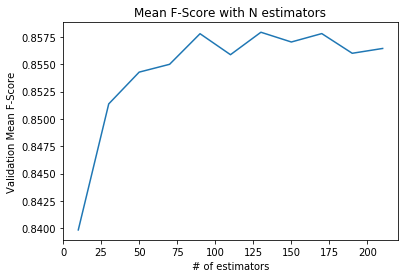

Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8581754735792622
Test Set Precision :  0.8819776714513556
Test Set Recall :  0.8270189431704885
Test F-Score for each class :  [0.86246072 0.85361461]
Test Mean F-Score for both classes :  0.858037666570339
Test Confusion Matrix :  [[1784  222]
 [ 347 1659]]
----------------------------------------------------------------------

Random First Standardized Data : 
Best n found at  {'n_estimators': 210}
Best Mean F-Score  0.8581594677365227


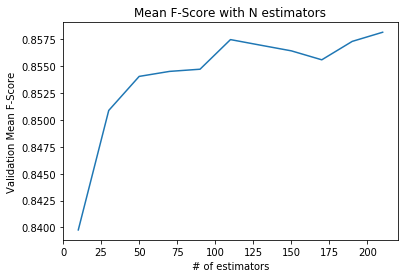

Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8556829511465603
Test Set Precision :  0.8769149498151083
Test Set Recall :  0.827517447657029
Test F-Score for each class :  [0.85963636 0.85150038]
Test Mean F-Score for both classes :  0.8555683741751965
Test Confusion Matrix :  [[1773  233]
 [ 346 1660]]
----------------------------------------------------------------------

Random First Pca Data : 
Best n found at  {'n_estimators': 130}
Best Mean F-Score  0.8437904963790707


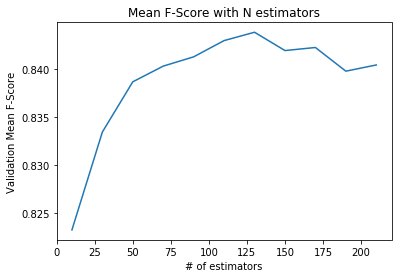

Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8377367896311066
Test Set Precision :  0.8563913729615992
Test Set Recall :  0.8115653040877367
Test F-Score for each class :  [0.84187515 0.83337599]
Test Mean F-Score for both classes :  0.8376255718095713
Test Confusion Matrix :  [[1733  273]
 [ 378 1628]]
----------------------------------------------------------------------



In [0]:
n = list(range(10, 211, 20))
print('Random Forest Original Data : ')
randomForestModel(X_train, y_label_train, X_test, y_label_test, n)
print()
print('Random Forest Standardized Data : ')
randomForestModel(z_score_X_train, y_label_train, z_score_X_test, y_label_test, n)
print()
print('Random Forest Pca Data : ')
randomForestModel(pca_X_train, y_label_train, pca_X_test, y_label_test, n)
print()

## AdaBoost
* Use decision trees of 1 depth & 5 depth.
* We notice unlike random trees, increasing number of estimators can make performance worsen.
* Takes a long time to train.
* Best performance obtained from original data(consistent with decision trees) with depth of 5 and number of estimators 1200, F-score was 0.8452235616799761.

In [0]:
# AdaBoost Model
def adaboostModel(X_train, y_label_train, X_test, y_label_test, n, depth=1):
  clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth))
  parameters = {'n_estimators': n}
  gAda = GridSearchCV(clf, parameters,scoring = 'f1_macro', cv = 5, n_jobs = num_jobs)
  gAda.fit(X_train, y_label_train)
  print('Best n found at ', gAda.best_params_)
  print('Best Mean F-Score ', gAda.best_score_)
  cs = gAda.cv_results_['param_n_estimators']
  cs_score = gAda.cv_results_['mean_test_score']
  plt.title('Mean F-Score with N estimators')
  plt.plot(cs, cs_score)
  plt.xlabel('# of estimators')
  plt.ylabel('Validation Mean F-Score')
  plt.show()
  print_stats(gAda, X_train, y_label_train, X_test, y_label_test)

AdaBoost First Original Data(Decision tree with depth 1) : 
Best n found at  {'n_estimators': 700}
Best Mean F-Score  0.8259060340817674


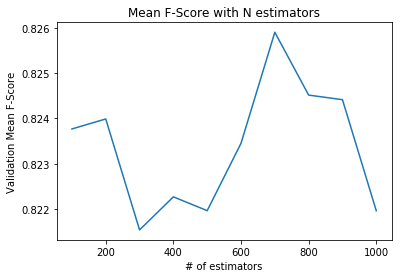

Train Set Accuracy :  0.8581802648440837
Train Set Precision :  0.8645652173913043
Train Set Recall :  0.8494233233660828
Train F-Score for each class :  [0.85941139 0.85692739]
Train Mean F-Score for both classes :  0.858169388702076
Train Confusion Matrix :  [[4059  623]
 [ 705 3977]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8195413758723828
Test Set Precision :  0.8280450358239508
Test Set Recall :  0.806580259222333
Test F-Score for each class :  [0.82185039 0.81717172]
Test Mean F-Score for both classes :  0.8195110554362521
Test Confusion Matrix :  [[1670  336]
 [ 388 1618]]
----------------------------------------------------------------------

AdaBoost First Standardized Data(Decision tree with depth 1) : 
Best n found at  {'n_estimators': 700}
Best Mean F-Score  0.8259060340817674


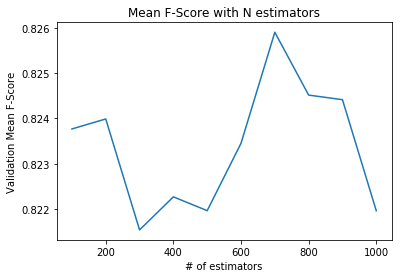

Train Set Accuracy :  0.8581802648440837
Train Set Precision :  0.8645652173913043
Train Set Recall :  0.8494233233660828
Train F-Score for each class :  [0.85941139 0.85692739]
Train Mean F-Score for both classes :  0.858169388702076
Train Confusion Matrix :  [[4059  623]
 [ 705 3977]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8195413758723828
Test Set Precision :  0.8280450358239508
Test Set Recall :  0.806580259222333
Test F-Score for each class :  [0.82185039 0.81717172]
Test Mean F-Score for both classes :  0.8195110554362521
Test Confusion Matrix :  [[1670  336]
 [ 388 1618]]
----------------------------------------------------------------------

AdaBoost First Pca Data(Decision tree with depth 1) : 
Best n found at  {'n_estimators': 600}
Best Mean F-Score  0.8060255046398472


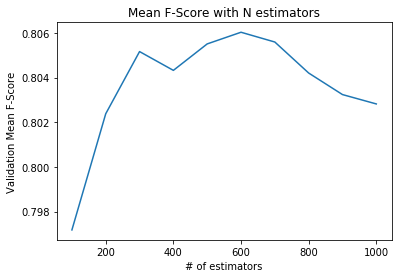

Train Set Accuracy :  0.836928662964545
Train Set Precision :  0.8475435117867371
Train Set Recall :  0.8216574113626656
Train F-Score for each class :  [0.83938151 0.83439974]
Train Mean F-Score for both classes :  0.8368906240434006
Train Confusion Matrix :  [[3990  692]
 [ 835 3847]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7966101694915254
Test Set Precision :  0.8158174097664543
Test Set Recall :  0.7662013958125623
Test F-Score for each class :  [0.80261248 0.79023136]
Test Mean F-Score for both classes :  0.7964219221628155
Test Confusion Matrix :  [[1659  347]
 [ 469 1537]]
----------------------------------------------------------------------



In [0]:
n = list(range(100, 1001, 100))
print('AdaBoost Original Data(Decision tree with depth 1) : ')
adaboostModel(X_train, y_label_train, X_test, y_label_test, n)
print()
print('AdaBoost Standardized Data(Decision tree with depth 1) : ')
adaboostModel(z_score_X_train, y_label_train, z_score_X_test, y_label_test, n)
print()
print('AdaBoost Pca Data(Decision tree with depth 1) : ')
adaboostModel(pca_X_train, y_label_train, pca_X_test, y_label_test, n)
print()


AdaBoost First Original Data(Decision tree with depth 5) : 
Best n found at  {'n_estimators': 1200}
Best Mean F-Score  0.8490901915107192


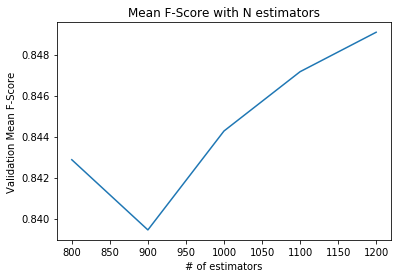

Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8454636091724825
Test Set Precision :  0.875
Test Set Recall :  0.8060817547357926
Test F-Score for each class :  [0.85131894 0.83912818]
Test Mean F-Score for both classes :  0.8452235616799761
Test Confusion Matrix :  [[1775  231]
 [ 389 1617]]
----------------------------------------------------------------------

AdaBoost First Standardized Data(Decision tree with depth 5) : 
Best n found at  {'n_estimators': 1000}
Best Mean F-Score  0.84715928920231


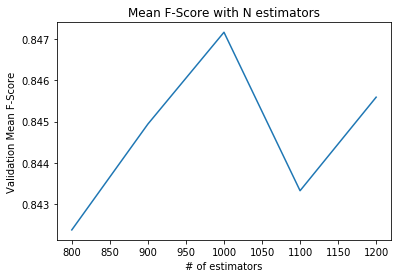

Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.8384845463609173
Test Set Precision :  0.8674242424242424
Test Set Recall :  0.7991026919242273
Test F-Score for each class :  [0.84460432 0.831863  ]
Test Mean F-Score for both classes :  0.8382336580139106
Test Confusion Matrix :  [[1761  245]
 [ 403 1603]]
----------------------------------------------------------------------

AdaBoost First Pca Data(Decision tree with depth 5) : 
Best n found at  {'n_estimators': 1100}
Best Mean F-Score  0.828208449742722


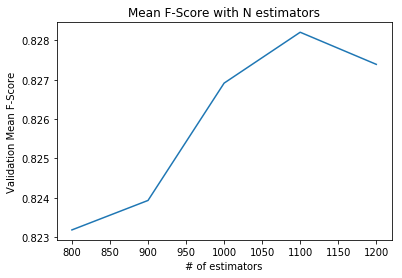

Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.827517447657029
Test Set Precision :  0.8613861386138614
Test Set Recall :  0.7806580259222333
Test F-Score for each class :  [0.8352381  0.81903766]
Test Mean F-Score for both classes :  0.8271378760709305
Test Confusion Matrix :  [[1754  252]
 [ 440 1566]]
----------------------------------------------------------------------



In [0]:
n = list(range(800, 1201, 100))
print('AdaBoost Original Data(Decision tree with depth 5) : ')
adaboostModel(X_train, y_label_train, X_test, y_label_test, n, 5)
print()
print('AdaBoost Standardized Data(Decision tree with depth 5) : ')
adaboostModel(z_score_X_train, y_label_train, z_score_X_test, y_label_test, n, 5)
print()
print('AdaBoost Pca Data(Decision tree with depth 5) : ')
adaboostModel(pca_X_train, y_label_train, pca_X_test, y_label_test, n, 5)
print()

## Conclusion
---
We notice that the performance of the ensemble methods is better than the other basic methods, with the decision tree being the best. We also see that pre-processing won't always lead to the best results and importance of hyper-parameter tuning with the cross-validation. Our data seemed to be easier to sepearte with multiple horizontal and vertical lines which explains the high performance of random forests, and adaBoost, decision trees. K-NN would also be good if tuned correctly, just slightly worse than a pre-pruned decision tree. Our data was not easily linearly separable which leads to poor performance of the SVM realtivly, and breaks the Naive-Bayesian assumption.

Best F-Scores:
1. Random Forest :  0.858037666570339
2. AdaBoost : 0.8452235616799761
3. Pre-pruned Decision Tree : 0.8101840289791009
4. K-NN : 0.8090860040466614
5. Decision Tree : 0.7928379102103247
6. SVM : 0.7733462801232129
7. Feature-Selection Naive-Bayesian(Coming After) : 0.7011598668877386
8. Naive-Bayesian : 0.6894654751507103

---

### Additional Work
## Feature Selection
* Checking performance of just selecting the 4 features disucessed from the correlation matrix.
* We notice a reduction in the performance of decision trees, but a good improvement in Naive-Bayes, surpassing our obtained naive-Bayes from above.
* We notice how reducing from 10 attributes to 4 attributes, in our case reduced most of the classifiers, some more than other, in our case but improved the speed of calculations greatly. This was with our heuristicly chosen attributes, which means maybe with different feature selection, a better performance can be obtained.

Feature-Selected Data Decision Tree(Entropy) : 
Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7166001994017946
Test Set Precision :  0.7128858402743753
Test Set Recall :  0.7253240279162513
Test F-Score for each class :  [0.71410611 0.71905115]
Test Mean F-Score for both classes :  0.7165786295662626
Test Confusion Matrix :  [[1420  586]
 [ 551 1455]]
----------------------------------------------------------------------

Naive Bayes Feature-Select data : 
Train Set Accuracy :  0.7173216574113627
Train Set Precision :  0.7997054491899853
Train Set Recall :  0.5798803929944468
Train F-Score for each class :  [0.75147873 0.67227931]
Train Mean F-Score for both classes :  0.7118790230083702
Train Confusion Matrix :  [[4002  680]
 [1

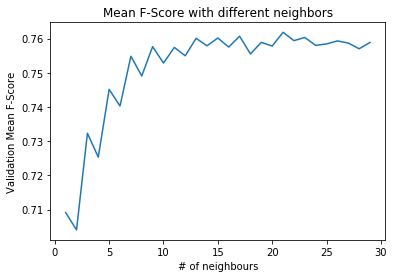

Train Set Accuracy :  0.7900469884664674
Train Set Precision :  0.818629751290474
Train Set Recall :  0.745194361384024
Train F-Score for each class :  [0.79905969 0.78018784]
Train Mean F-Score for both classes :  0.789623762354514
Train Confusion Matrix :  [[3909  773]
 [1193 3489]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7622133599202393
Test Set Precision :  0.790929203539823
Test Set Recall :  0.7128614157527418
Test F-Score for each class :  [0.77339667 0.7498689 ]
Test Mean F-Score for both classes :  0.7616327893110393
Test Confusion Matrix :  [[1628  378]
 [ 576 1430]]
----------------------------------------------------------------------

SVM Feature-Selected data
Best C found at  {'C': 1}
Best Mean F-Score  0.7342495650410293


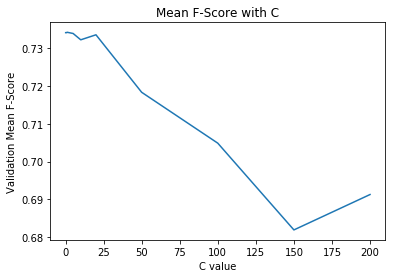

Train Set Accuracy :  0.7355830841520717
Train Set Precision :  0.7806615776081425
Train Set Recall :  0.6552755232806493
Train F-Score for each class :  [0.75523922 0.71249419]
Train Mean F-Score for both classes :  0.7338667095689078
Train Confusion Matrix :  [[3820  862]
 [1614 3068]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7325523429710867
Test Set Precision :  0.7801801801801802
Test Set Recall :  0.6475573280159521
Test F-Score for each class :  [0.75350333 0.70770907]
Test Mean F-Score for both classes :  0.7306062010669303
Test Confusion Matrix :  [[1640  366]
 [ 707 1299]]
----------------------------------------------------------------------

Random First Feature-Selected Data : 
Best n found at  {'n_estimators': 190}
Best Mean F-Score  0.7696193699011249


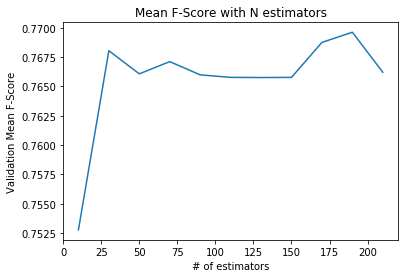

Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7771684945164506
Test Set Precision :  0.7808080808080808
Test Set Recall :  0.7706879361914257
Test F-Score for each class :  [0.77860327 0.775715  ]
Test Mean F-Score for both classes :  0.7771591357269014
Test Confusion Matrix :  [[1572  434]
 [ 460 1546]]
----------------------------------------------------------------------

AdaBoost First Feature-Selected Data(Decision tree with depth 1) : 
Best n found at  {'n_estimators': 200}
Best Mean F-Score  0.7584014700849868


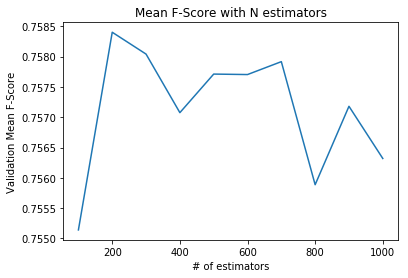

Train Set Accuracy :  0.7746689448953439
Train Set Precision :  0.7654830718414534
Train Set Recall :  0.7919692439128577
Train F-Score for each class :  [0.77070202 0.77850094]
Train Mean F-Score for both classes :  0.7746014830412087
Train Confusion Matrix :  [[3546 1136]
 [ 974 3708]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7517447657028913
Test Set Precision :  0.7441972920696325
Test Set Recall :  0.767198404785643
Test F-Score for each class :  [0.7478481  0.75552283]
Test Mean F-Score for both classes :  0.7516854644767994
Test Confusion Matrix :  [[1477  529]
 [ 467 1539]]
----------------------------------------------------------------------

AdaBoost First Feature-Selected Data(Decision tree with depth 5) : 
Best n found at  {'n_estimators': 1100}
Best Mean F-Score  0.7484237766454375


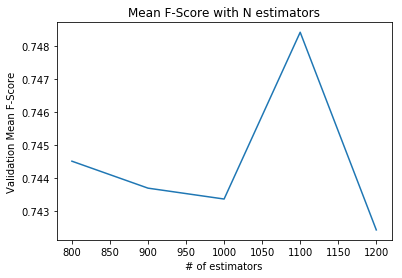

Train Set Accuracy :  1.0
Train Set Precision :  1.0
Train Set Recall :  1.0
Train F-Score for each class :  [1. 1.]
Train Mean F-Score for both classes :  1.0
Train Confusion Matrix :  [[4682    0]
 [   0 4682]]
----------------------------------------------------------------------
Test Set Accuracy :  0.7440179461615155
Test Set Precision :  0.7501277465508431
Test Set Recall :  0.7318045862412762
Test F-Score for each class :  [0.74710662 0.74085289]
Test Mean F-Score for both classes :  0.7439797566047874
Test Confusion Matrix :  [[1517  489]
 [ 538 1468]]
----------------------------------------------------------------------



In [0]:
# Feature Selection.
fs_X_train = z_score_X_train[:,[3,5,7,8]]
fs_X_test = z_score_X_test[:,[3,5,7,8]]


# Decision tree after feature selection
print('Feature-Selected Data Decision Tree(Entropy) : ')
decisionTreeModel(fs_X_train, y_label_train, fs_X_test, y_label_test, criterion='entropy')
print()

print('Naive Bayes Feature-Select data : ')
naiveBayesModel(fs_X_train, y_label_train, fs_X_test, y_label_test)
print()

print('KNN Feature-Selected Data : ')
kNearestNeighborsModel(fs_X_train, y_label_train, fs_X_test, y_label_test, start_n, end_n)
print()

print('SVM Feature-Selected data')
svmModel(fs_X_train, y_label_train, fs_X_test, y_label_test, c)
print()

n = list(range(10, 211, 20))
print('Random Forest Feature-Selected Data : ')
randomForestModel(fs_X_train, y_label_train, fs_X_test, y_label_test, n)
print()


n = list(range(100, 1001, 100))
print('AdaBoost Feature-Selected Data(Decision tree with depth 1) : ')
adaboostModel(fs_X_train, y_label_train, fs_X_test, y_label_test, n)
print()

n = list(range(800, 1201, 100))
print('AdaBoost Feature-Selected Data(Decision tree with depth 5) : ')
adaboostModel(fs_X_train, y_label_train, fs_X_test, y_label_test, n, 5)
print()